In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import torch
from datasets import load_from_disk, load_dataset
import copy

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import pynvml

# from repe import repe_pipeline_registry
# repe_pipeline_registry()

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    print(pynvml.nvmlDeviceGetName(handle))

/scratch/network/xz4134/miniconda/miniconda_envs/repe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NVIDIA A100-PCIE-40GB


In [3]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

user_tag = "USER:"
assistant_tag = "ASSISTANT:"

# Uncomment for first time loading the dataset
# ds = load_dataset('tatsu-lab/alpaca', cache_dir='../../storage/cache')
# ds.save_to_disk("../../storage/cache/alpaca_filtered/")

ds = load_from_disk('../../storage/cache/alpaca_filtered/')
instructions = ds['train']['instruction']
outputs = ds['train']['output']

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]


In [4]:
template_start = "{user_tag} {instruction} {aug_start}"
template_end = "{aug_end} {assistant_tag} {response}"
# Not sure why they set this offset
cutoff_offset = 0

def get_augmented_ds_tokenmod(instructions,
                              responses,
                              aug_start,
                              aug_var,
                              aug_end,
                              max_res_len,
                              num_examples,
                              user_tag,
                              assistant_tag,
                              aug_var_length=1,
                              ):
    
    ds = []
    aug_var_tokens = tokenizer.tokenize(aug_var)
    assert len(aug_var_tokens) == aug_var_length, aug_var_tokens

    for i, (q, a) in tqdm(enumerate(zip(instructions, responses))):
        
        # Replaced \n since it resulted in nontrivial peak
        # s_tokens = tokenizer.tokenize(s)
        a_tokens = tokenizer.tokenize(a.replace("\n", ""))

        l_start = template_start.format(
            user_tag=user_tag,
            instruction=q,
            aug_start=aug_start
        )

        l_end_base = template_end.format(
            aug_end=aug_end,
            assistant_tag=assistant_tag,
            response="",
        )
        end_token_offset = len(tokenizer.tokenize(l_end_base))

        for cutoff in range(1, min(max_res_len, len(a_tokens)) - cutoff_offset):
            a_truncated = tokenizer.convert_tokens_to_string(a_tokens[:cutoff])
            l_end = template_end.format(
                aug_end=aug_end,
                assistant_tag=assistant_tag,
                response=a_truncated,
            )
            neg_aug_var_offset = -end_token_offset - cutoff + 1
            var_token_inds = list(range(neg_aug_var_offset - aug_var_length, neg_aug_var_offset))
            l = " ".join([l_start, aug_var, l_end])
            ds.append([l, var_token_inds, (i, cutoff)])         
            if len(ds) >= num_examples:
                break
        if len(ds) >= num_examples:
            break
    return ds

In [16]:
max_res_len = 128
n_samples = 1000

aug_start = "Respond with a"
aug_end = "tone."

aug_neutral = "normal"
aug_target = "angry"
aug_token_len = 1

neutral_ds = get_augmented_ds_tokenmod(
    instructions,
    outputs,
    aug_start,
    aug_neutral,
    aug_end,
    max_res_len,
    n_samples,
    user_tag,
    assistant_tag,
    aug_token_len
)

target_ds = get_augmented_ds_tokenmod(
    instructions,
    outputs,
    aug_start,
    aug_target,
    aug_end,
    max_res_len,
    n_samples,
    user_tag,
    assistant_tag,
    aug_token_len
)

0it [00:00, ?it/s]

17it [00:00, 751.13it/s]
17it [00:00, 769.13it/s]


In [17]:
def get_hidden_reps(model, tokenizer, input_str, rep_tokens=[-1]):
    inputs = tokenizer(input_str, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs, output_hidden_states=True)
    return [m[:, rep_tokens] for m in outputs.hidden_states]

In [18]:
def get_seq_embedding(seq, tokenizer, model):
    
    tokens = tokenizer(seq, return_tensors="pt").to(model.model.device)
    embedding = (model.model.embed_tokens(tokens['input_ids'][:, 1:]))
    return embedding.squeeze().detach()

In [19]:
# wrapping classes for customized injection

class WrappedModBlock(torch.nn.Module):
    def __init__(self, block):
        super().__init__()
        self.block = block
        self.mod = None
        self.pos = None
        self.mask = None
        self.mod_method = None

        self.verbose = False

    def forward(self, *args, **kwargs):

        output = self.block(*args, **kwargs)
        # print(output.shape)
        # mask = self.mask if self.mask is not None else 1.0

        if self.mod is not None:

            if isinstance(self.pos[0], int):
                assert len(self.mod.shape) == 3
                if self.mod_method == "add":
                    output[:, self.pos] += self.mod
                elif self.mod_method == "substitute":
                    output[:, self.pos] = self.mod
                else:
                    raise NotImplementedError("pos dimension not implemented")
                # self.modify(output[:, self.pos], self.mod)
                if self.verbose:
                    print("Modifying with broadcasting: pos:{} modshape:{}".format(self.pos, self.mod.shape))

            elif isinstance(self.pos[0], list) or isinstance(self.pos[0], torch.Tensor): # assume the modification differs for different elements in the batch
                if self.verbose:
                    print("Modifying iteratively: pos:{}".format(self.pos))
                assert len(self.pos) == len(self.mod)
                for i in range(len(self.pos)):
                    if self.mod_method == "add":
                        output[i, self.pos] += self.mod[i]
                    elif self.mod_method == "substitute":
                        output[i, self.pos] = self.mod[i]
                    else:
                        raise NotImplementedError("pos dimension not implemented")
                    # self.modify(output[:, self.pos], self.mod)
            else:
                raise NotImplementedError("Indexing not accepted")

        return output

    def set_mod(self, mod, pos, mod_method, verbose=False):
        self.mod = mod
        # self.mask = masks
        self.pos = pos
        self.mod_method = mod_method
        self.verbose = verbose

    def reset(self):
        self.output = None
        self.mod = None
        self.pos = None
        self.verbose = False

    def set_masks(self, masks):
        self.mask = masks

    
class WrappedModModel(torch.nn.Module):
    def __init__(self, model, tokenizer, verbose=False):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.verbose = verbose
        if verbose:
            print("Creating wrapped model")
        
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
        
    def generate(self, prompt, max_new_tokens=100, random_seed=0, use_cache=True):
        with torch.no_grad():
            torch.random.manual_seed(random_seed)
            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, max_length=512, truncation=True)
            attention_mask = inputs.attention_mask.to(self.model.device)
            generate_ids = self.model.generate(inputs.input_ids.to(self.model.device), attention_mask=attention_mask, max_new_tokens=max_new_tokens, use_cache=use_cache)
            return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    def get_logits(self, tokens):
        with torch.no_grad():
            logits = self.model(tokens.to(self.model.device)).logits
            return logits
        
    def run_prompt(self, prompt, **kwargs):
        with torch.no_grad():
            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, max_length=512, truncation=True)
            input_ids = inputs.input_ids.to(self.model.device)
            attention_mask = inputs.attention_mask.to(self.model.device)
            output = self.model(input_ids, attention_mask=attention_mask)
            return output
        
    def wrap_decoder_block(self, layer_id):
        block = self.model.model.layers[layer_id]
        if not self.is_wrapped(block):
            self.model.model.layers[layer_id] = WrappedModBlock(block)
    
    def wrap_embedding_block(self):
        block = self.model.model.embed_tokens
        if not self.is_wrapped(block):
            self.model.model.embed_tokens = WrappedModBlock(block)
    
    def wrap_all(self):
        for layer_id, layer in enumerate(self.model.model.layers):
            self.wrap_decoder_block(layer_id)
            
    def wrap_block(self, layer_ids):
        def _wrap_block(layer_id):
            self.wrap_decoder_block(layer_id)
        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            for layer_id in layer_ids:
                _wrap_block(layer_id)
        else:
            _wrap_block(layer_ids)
    
    def wrap_embedding_block(self):
        block = self.model.model.embed_tokens
        if not self.is_wrapped(block):
            self.model.model.embed_tokens = WrappedModBlock(block)

    def get_activations(self, layer_ids):

        def _get_activations(layer_id):
            current_layer = self.model.model.layers[layer_id]

            if self.is_wrapped(current_layer):
                current_block = current_layer.block
                return current_layer.output
                
        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            activations = {}
            for layer_id in layer_ids:
                activations[layer_id] = _get_activations(layer_id)
            return activations
        else:
            return _get_activations(layer_ids)

    def set_mod(self, layer_ids, activations, block_name='decoder_block', pos=None, masks=None, normalize=False):

        def _set_mod(layer_id, activations, block_name, masks, normalize):
            current_layer = self.model.model.layers[layer_id]
            current_layer.set_mod(activations, pos, masks, normalize)
                
        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            assert isinstance(activations, dict), "activations should be a dictionary"
            for layer_id in layer_ids:
                _set_mod(layer_id, activations[layer_id], block_name, masks, normalize)
        else:
            _set_mod(layer_ids, activations, block_name, masks, normalize)
    
    def set_mod_embedding(self, mod, pos, mod_method="substitute"):
        block = self.model.model.embed_tokens
        assert self.is_wrapped(block)
        block.set_mod(mod, pos, mod_method, verbose=self.verbose)
        if self.verbose:
            print("Setting embedding modification")

    def reset(self):
        for layer in self.model.model.layers:
            if self.is_wrapped(layer):
                layer.reset()
        self.model.model.embed_tokens.reset()

    def set_masks(self, masks):
        for layer in self.model.model.layers:
            if self.is_wrapped(layer):
                layer.set_masks(masks)

    def is_wrapped(self, block):
        if hasattr(block, 'block'):
            return True
        return False
    
    def unwrap(self):
        for l, layer in enumerate(self.model.model.layers):
            if self.is_wrapped(layer):
                self.model.model.layers[l] = layer.block
        if self.is_wrapped(self.model.model.embed_tokens):
            self.model.model.embed_tokens = model.model.embed_tokens.block



In [20]:

wrapped_model = WrappedModModel(model, tokenizer, verbose=False)
wrapped_model.unwrap()
wrapped_model.wrap_embedding_block()
test_tokens = tokenizer(neutral_ds[0][0], return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
# wrapped_model(**test_tokens)
init_embedding = get_seq_embedding("_ _ _", tokenizer, model).unsqueeze(0)
test_pos = [-1, -2, -3]

wrapped_model.set_mod_embedding(init_embedding, test_pos)
wrapped_model(**test_tokens)
# get_hidden_reps(wrapped_model, tokenizer, neutral_ds[0][0])

# wrapped_model.reset()
get_hidden_reps(wrapped_model, tokenizer, neutral_ds[0][0], rep_tokens=[-1, -2])
print(init_embedding)

tensor([[[-0.0051, -0.0053,  0.0044,  ..., -0.0010, -0.0022,  0.0003],
         [-0.0051, -0.0053,  0.0044,  ..., -0.0010, -0.0022,  0.0003],
         [-0.0051, -0.0053,  0.0044,  ..., -0.0010, -0.0022,  0.0003]]],
       device='cuda:0', dtype=torch.float16)


In [21]:
def comp_reps(wrapped_model: WrappedModModel, tokenizer, input_strs, sample_ids, mod, mod_pos, rep_tokens, grad_comp=True):
    # Return hidden representation for (modified) inputs

    wrapped_model.reset()
    wrapped_model.model.zero_grad()
    if mod is not None:
        wrapped_model.set_mod_embedding(mod, mod_pos)
    
    tokenized_inputs = tokenizer(input_strs, return_tensors="pt", padding=True).to(wrapped_model.model.device)
    if not grad_comp:
        with torch.no_grad():
            outputs = model(**tokenized_inputs, output_hidden_states=True)
    else:
        outputs = model(**tokenized_inputs, output_hidden_states=True)
    reps = [m[:, rep_tokens] for m in outputs.hidden_states]
    assert len(sample_ids) == reps[0].shape[0], "sample_id passed incorrectly"
    
    res = {sample_id: [x[i] for x in reps] for i, sample_id in enumerate(sample_ids)}
    return res, outputs

def comp_target_reps_interpolation(reps_init, reps_dest, dest_weight):
    # Interpolate between reps_init and reps_dest
    res = {}
    for k in reps_init.keys():
        l = []
        for i in range(len(reps_init[k])):
            l.append((reps_init[k][i] * (1 - dest_weight) + reps_dest[k][i] * dest_weight).detach())
            # print(torch.norm(reps_init[k][i] - reps_dest[k][i]))
        res[k] = l
    return res

In [22]:
def l2_rep_diff(base, target, layer_ids):
    loss = 0
    for l in layer_ids:
        # print(base[l], target[l])
        loss += torch.norm(base[l] - target[l])
    return loss

In [30]:
def train_contrastive(model, tokenizer, ds_dest, init_str, target_str, epochs, batchsize, rep_tokens, coef=1, caching_base=True):

    cached_target_reps = {}
    loss_record = []

    # Created wrapped model for injection
    wrapped_model = WrappedModModel(model, tokenizer, verbose=False)
    wrapped_model.unwrap()
    wrapped_model.wrap_embedding_block()
    wrapped_model.reset()

    embedding_init = get_seq_embedding(init_str, tokenizer, wrapped_model.model)
    # print(embedding_init)

    var_embedding = embedding_init.clone().float()
    optimizer = torch.optim.SGD([var_embedding], lr=0.001)
    # var_embedding.requires_grad = True

    for i in range(epochs):
        for batch_ind in range((len(ds_dest) + batchsize - 1) // batchsize):

            if device != "cpu":
                info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                print(info.free / info.total)
            
            # Compute or retrive target representation
            sample_id_ls = [] # all sample ids
            sample_id_ls_target_recomp = [] # ids not found in cache

            input_strs, mod_pos_ls = [], []
            input_strs_target_recomp, mod_pos_ls_target_recomp = [], []
            
            for target_str, mod_pos, sample_id in ds_dest[batch_ind * batchsize : (batch_ind + 1) * batchsize]:
                
                # sample_id: (i, j) - the j-th truncation for the i-th sentence
                sample_id_ls.append(sample_id)
                input_strs.append(target_str)
                mod_pos_ls.append(mod_pos)
                
                if sample_id not in cached_target_reps:
                    sample_id_ls_target_recomp.append(sample_id)
                    input_strs_target_recomp.append(target_str)
                    mod_pos_ls_target_recomp.append(mod_pos)
                
            # Compute reps at init and target token
            if len(sample_id_ls_target_recomp) != 0:
                # Recompute
                reps_init_recomp, _ = comp_reps(
                    wrapped_model,
                    tokenizer,
                    input_strs_target_recomp,
                    sample_id_ls_target_recomp,
                    mod=[embedding_init.clone() for i in range(len(sample_id_ls_target_recomp))],
                    mod_pos=mod_pos_ls_target_recomp,
                    rep_tokens=rep_tokens,
                    grad_comp=False
                )

                reps_dest_recomp, _ = comp_reps(
                    wrapped_model,
                    tokenizer,
                    input_strs_target_recomp,
                    sample_id_ls_target_recomp,
                    mod=None,
                    mod_pos=None,
                    rep_tokens=rep_tokens,
                    grad_comp=False
                )

                reps_target_recomp = comp_target_reps_interpolation(reps_init_recomp, reps_dest_recomp, coef)
                cached_target_reps.update(reps_target_recomp)

            reps_target = {sample_id: cached_target_reps[sample_id] for sample_id in sample_id_ls}
            # Compute the representation with the varying embedding

            # Create the varying embedding representations
            var_embedding_dups = [var_embedding.clone().half() for i in range(len(sample_id_ls))]
            for x in var_embedding_dups:
                x.requires_grad = True

            reps_var, all_reps = comp_reps(
                wrapped_model,
                tokenizer,
                input_strs,
                sample_id_ls,
                mod=var_embedding_dups,
                mod_pos=mod_pos_ls,
                rep_tokens=rep_tokens,
                grad_comp=True
            )
            # print(var_embedding_dups)

            # Compute representation difference in l2 metric
            losses = {}
            for sample_id in reps_var:
                losses[sample_id] = l2_rep_diff(reps_var[sample_id], reps_target[sample_id], [-5])
            
            # Back prop the loss to modified embeddings
            total_loss = 0
            for sample_id in losses:
                total_loss += losses[sample_id]
            total_loss.backward()
            del all_reps
            print(total_loss)
            
            # for i in range(len(var_embedding_dups)):
            #     print(i, var_embedding_dups[i].grad)

            # tokenized_var_strs = tokenizer(var_strs, return_tensors="pt", padding=True).to(model.device)
            # print(model(**tokenized_var_strs))
            optimizer.zero_grad()
            ave_grad = torch.mean(torch.stack([var_embedding_dups[i].grad for i in range(len(var_embedding_dups))]), dim=0)
            var_embedding.grad = ave_grad.float()
            
            optimizer.step()

            wrapped_model.model.model.zero_grad()
            for x in var_embedding_dups:
                del x
            
            if not caching_base:
                cached_target_reps = {}
            
            loss_record.append(total_loss.detach().item())

            

    return loss_record, var_embedding
res = train_contrastive(model, tokenizer, target_ds, aug_neutral, aug_target, epochs=5, batchsize=8, rep_tokens=[-1], coef=1, caching_base=False)

0.07204132080078125
tensor(181., device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(132.5000, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(124.6875, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(72.4375, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(107.1875, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(108.3750, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(154.1250, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(165.2500, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(84.6875, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.07204132080078125
tensor(84.8125, device='cuda:0', dtype=torch.float16, grad_fn=<AddBackward0>)
0.072041320800781

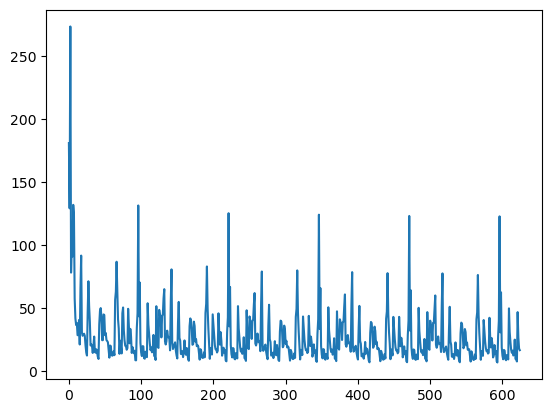

In [24]:
plt.plot(res)

In [25]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

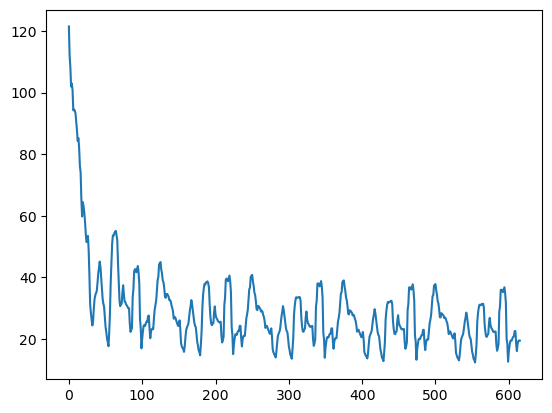

In [32]:
plt.plot(moving_average(res[0], 10))

In [14]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14340 MiB |  29047 MiB |  28681 GiB |  28667 GiB |
|       from large pool |  14340 MiB |  29037 MiB |  28389 GiB |  28375 GiB |
|       from small pool |      0 MiB |    186 MiB |    291 GiB |    291 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  14340 MiB |  29047 MiB |  28681 GiB |  28667 GiB |
|       from large pool |  14340 MiB |  29037 MiB |  28389 GiB |